# Data/Process/Operational Historian

## Introduction

### Terminology

* **DCS**: Distributed Control System

* **Database**: An organized collection of data that is stored and accessed electronically. Databases are a major industry and one of the most significant technologies underpinning the modern global economy.

    * **Ralational database**: Data organized as linked collections of tables comprised of rows and columns. Structured Query Language (SQL) is a specialized language for writing and querying relational databases. 
    * **NoSQL database**: Typically organized as key-value pairs, NoSQL databases encompass a broad range of technologies used in modern web applications and extremely large scale databases.
    * **Time-series database**: Data organized in time series consisting of time-value pairs, often organized as traces, curves, or trends. Typically used in industrial applications.
    
    
* **[Data | Operational | Process] Historian**: A time-series database used to store and access operational process data. 

### Major Vendors of Data Historians

Data historians is about a $1B/year market globally, poised to grow much larger with the emerging **Industrial Internet of Things (IIoT)** market.

* GE, IBM, Hitachi-ABB, Rockwell Automation, Emerson, Honeywell, Siemens, AVEVA, OSIsoft, ICONICS, Yokogawa, PTC, Inductive Automation, Canary Labs, Open Automation Software, InfluxData, Progea, Kx Systems, SORBA, Savigent Software, Automsoft, LiveData Utilities, Industrial Video & Control, Aspen Technology, and COPA-DATA

### Example: OSIsoft PI System

* One of the market leaders is OSIsoft which markets their proprietary PI system. Founded in 1980, OSIsoft now has 1,400 employees and recently announced sale of the company for $5B to AVENA.

* The PI system is integrated suite of tools supporting the storage and retreival of process data in a time-series data base.

![](https://storage.googleapis.com/gweb-cloudblog-publish/images/GCP_deployment_scripts_for_PI_Core.max-1400x1400.jpg)



### Process Analytics

Process analytics refers to analytical tools that use the data historian to provide usable information about the underlying processes. 

## The tclab Data Historian

The tclab Python library support the Temperature Control Lab includes a very basic and no-frills implementation of a time-series data base. The purposes of the data historian are to 

* enable the collection and display of data durinig the course of developing control strategies, and
* enable post-experiment analysis using standard Python libraries such as Pandas.

Documentatiion is available for the tclab [Historian](https://tclab.readthedocs.io/en/latest/notebooks/05_TCLab_Historian.html) and associated [Plotter](https://tclab.readthedocs.io/en/latest/notebooks/06_TCLab_Plotter.html) modules.

Historian is implemented using [SQLite](https://www.sqlite.org/index.html), a small, self-contained SQL data system in the public domain. SQLite was originally developed in 2000 by D. Richard Hipp who was designing software for a damage-control systems used in the U.S. Navy aboard guided missile destroyers. Since then it has become widely used in embedded systems including most laptops, smartphones, and browsers. If you used Apple photos, messaging on your smartphone, GPS units in your car, then you've used SQLite. It estimated there are over 1 trillion SQLite databases in active use. Much of the success is to due to the licensing terms (free!) and an extraordinarily level of automated code testing assuring a high level of reliability.

Below we will introduce useful capabilities of the Historian that will prove useful as we explore more sophisticated control algorithms and strategies.

* Data logging
* Acessing data

### Data Logging

#### Creating a log

An instance of a data historian is created by providing a list of data sources. An instance of a `lab` created by `TCLab()` provides a default list of sources in `lab.sources`.

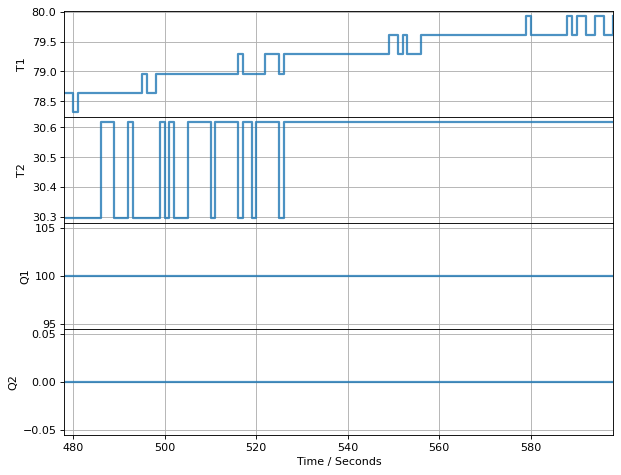

TCLab Model disconnected successfully.


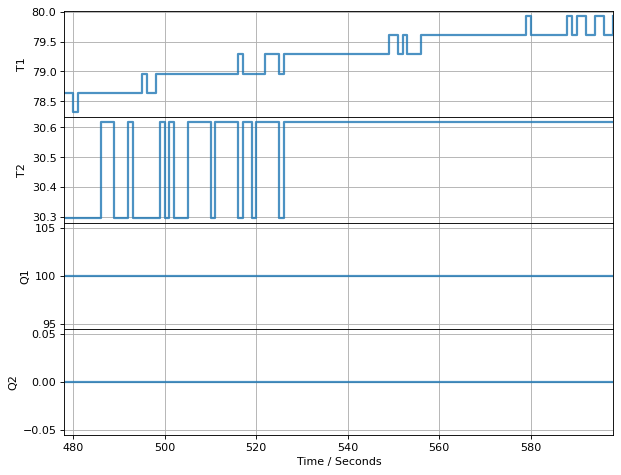

In [2]:
from tclab import setup, clock, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

with TCLab() as lab:
    h = Historian(lab.sources)  # <= creates an instance of an historian with default lab.sources
    p = Plotter(h)
    lab.Q1(100)
    for t in clock(600):
        p.update(t)             # <= updates the historian at time t
        
# note that the historian lives on after we're finished with lab

#### Accessing Data using `.columns` and `.fields`

There are several approaches to accessing the data that has been recorded using the historian. Perhaps the most straightforward is to access the 'tags' with `h.columns` and to access the values with `h.fields` as shown here.

In [3]:
# columns property consists of all data being logged
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2']

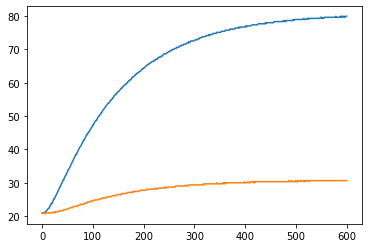

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

t, T1, T2, Q1, Q1 = h.fields   # <= access data using h.fields
plt.plot(t, T1, t, T2)         # <= plot data 

#### Accessing Data using `pandas`

The Python `pandas` library provides an enormous range of commonly tools for data analysis, it is among the most widely used libraries by data scientists. Data collected by the historian can be converted to a pandas data frame with one line of code.

,T1,T2,Q1,Q2
Time,,,,
0.00,20.9495,20.9495,100,0
3.03,20.9495,20.9495,100,0
4.03,20.9495,20.9495,100,0
6.01,21.2718,20.6272,100,0
7.02,21.2718,20.9495,100,0


<AxesSubplot:xlabel='Time'>

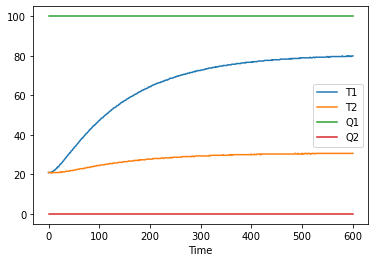

In [5]:
import pandas as pd
df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')

display(df.head())
df.plot()

#### Specifying additional sources

As we develop increasingly complex control algorthms, we will wish to record additional data during the course of an experiment. This is done by specifying data sources. Each source is defined by a `(tag, fcn)` pair where `tag` is string label for data, and `fcn` is a function with no arguments that returns a current value. An example is 

    ['Q1', lab.Q1]
    
where `Q1` is the tag, and `lab.Q1()` returns the current value of heater power reported by the hardware.

The following cell presents an example where two setpoints are provided for two control loops. The setpoint tags are `SP1` and `SP2`, respectively. Setpoint `SP1` is specified as a Python constant. The historian requires a function that returns the value of the  which is a function of time. This has to be 

    ['SP1', SP1]
    

In [8]:
from tclab import setup, clock, Historian

# proportional control gain
Kp = 4.0

# setpoint 1
SP1 = 30.0

# setpoint function
SP2 = 30.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(['SP1', lambda: SP1])
    sources.append(['SP2', lambda: SP2])
    h = Historian(sources)
    for t in clock(600):
        U1 = Kp*(SP1 - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


### Persistence

#### Saving to a file

In [19]:
h.to_csv("data/saved_data.csv")

In [20]:
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2', 'SP1', 'SP2']

In [22]:
import pandas as pd
df = pd.read_csv("data/saved_data.csv")
df.head()

,Time,T1,T2,Q1,Q2,SP1,SP2
0,0.00,20.9495,20.9495,0.0,100,20.0,40.0
1,14.00,20.9495,21.9164,0.0,100,20.0,40.0
2,15.04,20.9495,21.9164,0.0,100,20.0,40.0
3,16.05,20.9495,21.9164,0.0,100,20.0,40.0
4,18.01,20.9495,22.2387,0.0,100,20.0,40.0


<AxesSubplot:xlabel='Time'>

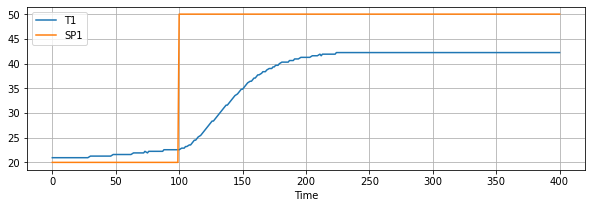

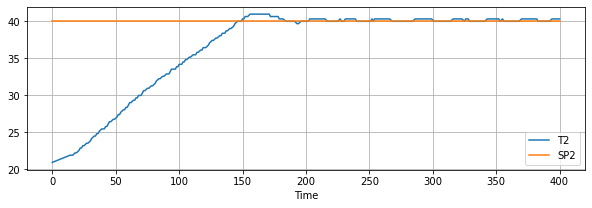

In [33]:
df.plot(x="Time", y=["T1", "SP1"], grid=True, figsize=(10, 3))
df.plot(x="Time", y=["T2", "SP2"], grid=True, figsize=(10, 3))

In [56]:
from tclab import setup, clock, Historian

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

# setpoint function
SP2 = 40.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(['SP1', lambda: SP1(t)])
    sources.append(['SP2', lambda: SP2])
    h = Historian(sources, dbfile="data/tclab_historian.db")
    for t in clock(600):
        U1 = Kp*(SP1(t) - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        h.update(t)

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


<AxesSubplot:xlabel='Time'>

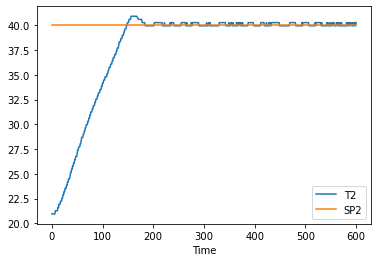

In [62]:
h.get_sessions()
h.load_session(6)
h.columns
df = pd.DataFrame(h.log, columns=h.columns)
df.plot(x="Time", y=["T2", "SP2"])

In [49]:
from tclab import Historian
h = Historian([], dbfile="data/tclab_historian.db")
h.get_sessions()

[(1, '2021-03-16 17:07:35', 164),
 (2, '2021-03-16 17:12:20', 593),
 (3, '2021-03-16 17:12:32', 301),
 (4, '2021-03-16 17:15:51', 592),
 (5, '2021-03-16 17:16:02', 302),
 (6, '2022-03-01 16:23:16', 598),
 (7, '2022-03-01 16:23:40', 293),
 (8, '2022-03-01 16:33:50', 601),
 (9, '2022-03-01 16:48:35', 0)]

In [50]:
h.db.delete_session(9)
h.db.delete_session(10)
h.get_sessions()

[(1, '2021-03-16 17:07:35', 164),
 (2, '2021-03-16 17:12:20', 593),
 (3, '2021-03-16 17:12:32', 301),
 (4, '2021-03-16 17:15:51', 592),
 (5, '2021-03-16 17:16:02', 302),
 (6, '2022-03-01 16:23:16', 598),
 (7, '2022-03-01 16:23:40', 293),
 (8, '2022-03-01 16:33:50', 601)]

## Plotter

The `Plotter` class provides a real-time graphical interface to an historian. It provides some simple facilities for 

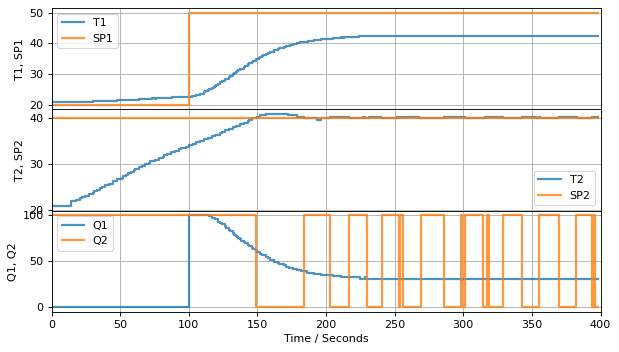

TCLab Model disconnected successfully.


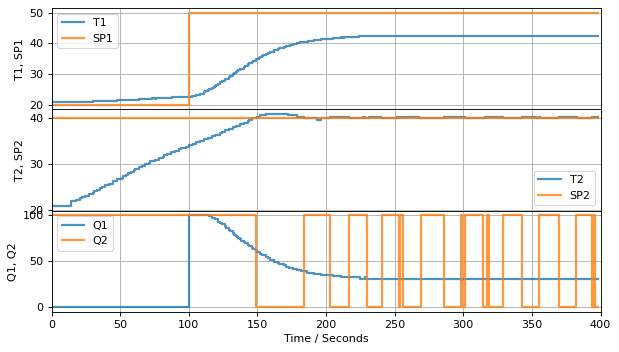

In [16]:
from tclab import setup, clock, Historian, Plotter

# proportional control gain
Kp = 4.0

# setpoint function
def SP1(t):
    return 20.0 if t <= 100 else 50.0

# setpoint function
SP2 = 40.0

TCLab = setup(connected=False, speedup=60)

with TCLab() as lab:
    # add setpoint to default sources
    sources = lab.sources
    sources.append(['SP1', lambda: SP1(t)])
    sources.append(['SP2', lambda: SP2])
    h = Historian(sources, dbfile="data/tclab_historian.db")
    
    layout = [["T1", "SP1"], ["T2", "SP2"], ["Q1", "Q2"]]
    p = Plotter(h, 400, layout)
    for t in clock(400):
        U1 = Kp*(SP1(t) - lab.T1)
        U2 = 100 if lab.T2 < SP2 else 0
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

In [17]:
h.get_sessions()

[(1, '2021-03-16 17:07:35', 164),
 (2, '2021-03-16 17:12:20', 593),
 (3, '2021-03-16 17:12:32', 301),
 (4, '2021-03-16 17:15:51', 592),
 (5, '2021-03-16 17:16:02', 302),
 (6, '2022-03-01 16:23:16', 598),
 (7, '2022-03-01 16:23:40', 293)]

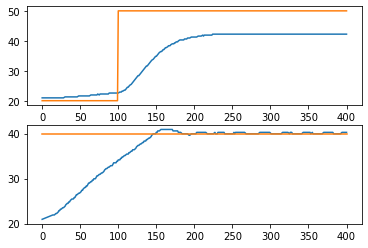

In [18]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(h.logdict["Time"], h.logdict["T1"], h.logdict["Time"], h.logdict["SP1"])
ax[1].plot(h.logdict["Time"], h.logdict["T2"], h.logdict["Time"], h.logdict["SP2"])